In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [13]:
class CustomVAE(nn.Module):
    def __init__(self, channels=3, latent_size=128, structure=[32, 64, 128, 256], img_res=32, num_classes=10):
        super(CustomVAE, self).__init__()
        self.img_res = img_res
        self.latent_size = latent_size
        self.num_classes = num_classes
        self.structure = structure

        enc_layers = []
        input_channels = channels + num_classes
        for out_channels in structure:
            enc_layers.append(
                nn.Sequential(
                    nn.Conv2d(input_channels, out_channels, kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU())
            )
            input_channels = out_channels
        self.encoder = nn.Sequential(*enc_layers)
        self.flat_size = structure[-1] * (img_res // (2 ** len(structure))) ** 2
        self.fc_mean = nn.Linear(self.flat_size, latent_size)
        self.fc_logvar = nn.Linear(self.flat_size, latent_size)

        dec_layers = []
        self.fc_dec = nn.Linear(latent_size + num_classes, self.flat_size)
        structure.reverse()
        for i in range(len(structure) - 1):
            dec_layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(structure[i], structure[i + 1], kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(structure[i + 1]),
                    nn.ReLU())
            )
        dec_layers.append(
            nn.Sequential(
                nn.ConvTranspose2d(structure[-1], channels, kernel_size=4, stride=2, padding=1),
                nn.Tanh())
        )
        self.decoder = nn.Sequential(*dec_layers)

    def encode(self, img, label):
        label = label.view(label.size(0), self.num_classes, 1, 1).repeat(1, 1, self.img_res, self.img_res)
        combined = torch.cat([img, label], dim=1)
        encoded = self.encoder(combined).view(combined.size(0), -1)
        return self.fc_mean(encoded), self.fc_logvar(encoded)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, label):
        z = torch.cat([z, label], dim=1)
        decoded = self.fc_dec(z).view(z.size(0), self.structure[0], self.img_res // (2 ** len(self.structure)), -1)
        return self.decoder(decoded)

    def forward(self, img, label):
        mean, logvar = self.encode(img, label)
        z = self.reparameterize(mean, logvar)
        return self.decode(z, label), mean, logvar

def compute_loss(reconstructed, original, mean, logvar):
    reconstruction_loss = nn.MSELoss()(reconstructed, original)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reconstruction_loss + 0.0001 * kl_divergence

def train_model(vae_model, dataloader, optimizer, device, num_epochs=15):
    vae_model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, labels in tqdm(dataloader, desc=f'Training Epoch {epoch + 1}/{num_epochs}'):
            labels = torch.nn.functional.one_hot(labels, num_classes=10).float()
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            reconstructed, mean, logvar = vae_model(images, labels)
            loss = compute_loss(reconstructed, images, mean, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch + 1}] - Loss: {epoch_loss / len(dataloader):.4f}")

In [15]:
config = {
    'batch_size': 64,
    'epochs': 20,
    'image_res': 32,
    'latent_size': 128,
    'learning_rate': 0.0002,
    'num_classes': 10,
    'workers': 4
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform_pipeline = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_pipeline)
data_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['workers'])

vae = CustomVAE(img_res=config['image_res'], latent_size=config['latent_size'], num_classes=config['num_classes']).to(device)
optimizer = optim.Adam(vae.parameters(), lr=config['learning_rate'])

train_model(vae, data_loader, optimizer, device, num_epochs=config['epochs'])
torch.save(vae.state_dict(), "cifar10_vae_model.pth")

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training Epoch 1/20: 100%|██████████| 782/782 [00:17<00:00, 45.69it/s]


Epoch [1] - Loss: 0.0935


Training Epoch 2/20: 100%|██████████| 782/782 [00:18<00:00, 43.00it/s]


Epoch [2] - Loss: 0.0571


Training Epoch 3/20: 100%|██████████| 782/782 [00:16<00:00, 46.06it/s]


Epoch [3] - Loss: 0.0550


Training Epoch 4/20: 100%|██████████| 782/782 [00:17<00:00, 45.13it/s]


Epoch [4] - Loss: 0.0544


Training Epoch 5/20: 100%|██████████| 782/782 [00:17<00:00, 45.85it/s]


Epoch [5] - Loss: 0.0537


Training Epoch 6/20: 100%|██████████| 782/782 [00:17<00:00, 44.60it/s]


Epoch [6] - Loss: 0.0517


Training Epoch 7/20: 100%|██████████| 782/782 [00:18<00:00, 42.10it/s]


Epoch [7] - Loss: 0.0508


Training Epoch 8/20: 100%|██████████| 782/782 [00:17<00:00, 45.62it/s]


Epoch [8] - Loss: 0.0507


Training Epoch 9/20: 100%|██████████| 782/782 [00:17<00:00, 45.46it/s]


Epoch [9] - Loss: 0.0505


Training Epoch 10/20: 100%|██████████| 782/782 [00:17<00:00, 45.68it/s]


Epoch [10] - Loss: 0.0503


Training Epoch 11/20: 100%|██████████| 782/782 [00:17<00:00, 43.63it/s]


Epoch [11] - Loss: 0.0503


Training Epoch 12/20: 100%|██████████| 782/782 [00:18<00:00, 42.48it/s]


Epoch [12] - Loss: 0.0501


Training Epoch 13/20: 100%|██████████| 782/782 [00:17<00:00, 45.12it/s]


Epoch [13] - Loss: 0.0500


Training Epoch 14/20: 100%|██████████| 782/782 [00:17<00:00, 45.50it/s]


Epoch [14] - Loss: 0.0500


Training Epoch 15/20: 100%|██████████| 782/782 [00:17<00:00, 44.79it/s]


Epoch [15] - Loss: 0.0500


Training Epoch 16/20: 100%|██████████| 782/782 [00:18<00:00, 42.21it/s]


Epoch [16] - Loss: 0.0499


Training Epoch 17/20: 100%|██████████| 782/782 [00:17<00:00, 44.83it/s]


Epoch [17] - Loss: 0.0498


Training Epoch 18/20: 100%|██████████| 782/782 [00:16<00:00, 46.50it/s]


Epoch [18] - Loss: 0.0499


Training Epoch 19/20: 100%|██████████| 782/782 [00:16<00:00, 46.86it/s]


Epoch [19] - Loss: 0.0498


Training Epoch 20/20: 100%|██████████| 782/782 [00:16<00:00, 46.98it/s]


Epoch [20] - Loss: 0.0498


In [18]:
import matplotlib.pyplot as plt

def visualize_reconstructions(vae_model, dataloader, device, num_images=10):
    vae_model.eval()
    images, labels = next(iter(dataloader))
    labels = torch.nn.functional.one_hot(labels, num_classes=10).float()
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        reconstructed, _, _ = vae_model(images, labels)

    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    reconstructed = reconstructed.cpu().numpy().transpose(0, 1, 2, 3)

    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

    for i in range(num_images):
        axes[0, i].imshow(images[i])
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        axes[1, i].imshow(reconstructed[i])
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

TypeError: Invalid shape (3, 32, 32) for image data

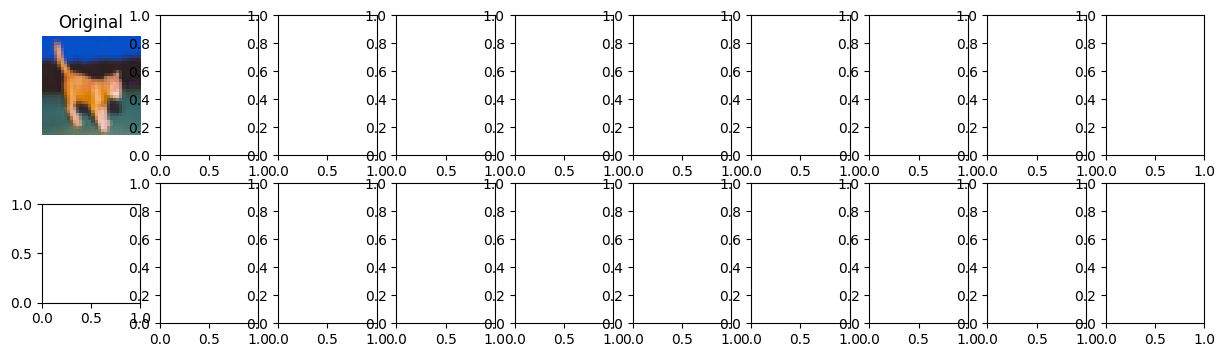

In [19]:
visualize_reconstructions(vae, data_loader, device, num_images=10)